## Initializing the context
We'll first setup the glue context in which we can read the glue data catalog, as well as setup some constants.

In [1]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

glueContext = GlueContext(SparkContext.getOrCreate())

database_name = "reinvent19"
canonical_table_name = "canonical"

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
9,application_1570414361246_0010,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Reading the Data using the Catalog
Using the glue context, we can read in the data.  This is done by using the glue data catalog and looking up the data

Here we can see there are ***500 million*** records

In [2]:
taxi_data = glueContext.create_dynamic_frame.from_catalog(database=database_name, table_name=canonical_table_name)
print("2018/2019 Taxi Data Count: ", taxi_data.count())
taxi_data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2018/2019 Taxi Data Count:  452091107
root
|-- pickup_datetime: timestamp
|-- dropoff_datetime: timestamp
|-- pulocationid: long
|-- dolocationid: long
|-- type: string
|-- vendorid: string

## DeepAR in SageMaker

The algorithm expects different formats, we'll use the JSON format here.

The records in your input files should contain the following fields:

    start—A string with the format YYYY-MM-DD HH:MM:SS. The start timestamp can't contain time zone information.

    target—An array of floating-point values or integers that represent the time series. You can encode missing values as null literals, or as "NaN" strings in JSON, or as nan floating-point values in Parquet.

    dynamic_feat (optional)—An array of arrays of floating-point values or integers that represents the vector of custom feature time series (dynamic features). If you set this field, all records must have the same number of inner arrays (the same number of feature time series). In addition, each inner array must have the same length as the associated target value. Missing values are not supported in the features. For example, if target time series represents the demand of different products, an associated dynamic_feat might be a boolean time-series which indicates whether a promotion was applied (1) to the particular product or not (0):

    {"start": ..., "target": [1, 5, 10, 2], "dynamic_feat": [[0, 1, 1, 0]]}

    cat (optional)—An array of categorical features that can be used to encode the groups that the record belongs to. Categorical features must be encoded as a 0-based sequence of positive integers. For example, the categorical domain {R, G, B} can be encoded as {0, 1, 2}. All values from each categorical domain must be represented in the training dataset. That's because the DeepAR algorithm can forecast only for categories that have been observed during training. And, each categorical feature is embedded in a low-dimensional space whose dimensionality is controlled by the embedding_dimension hyperparameter. For more information, see DeepAR Hyperparameters.

## Caching in Spark
We'll use the taxi dataframe a bit repeatitively, so we'll cache it ehre and show some sample records.

In [3]:
df = taxi_data.toDF().cache()
df.show(30, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------------+------------+------------+----+--------+
|pickup_datetime    |dropoff_datetime|pulocationid|dolocationid|type|vendorid|
+-------------------+----------------+------------+------------+----+--------+
|2018-01-30 21:15:34|null            |129         |null        |fhv |fhv     |
|2018-01-30 21:35:29|null            |112         |null        |fhv |fhv     |
|2018-01-30 21:16:34|null            |42          |null        |fhv |fhv     |
|2018-01-30 21:40:35|null            |131         |null        |fhv |fhv     |
|2018-01-30 21:49:59|null            |121         |null        |fhv |fhv     |
|2018-01-30 21:44:55|null            |235         |null        |fhv |fhv     |
|2018-01-30 21:51:30|null            |235         |null        |fhv |fhv     |
|2018-01-30 22:15:28|null            |208         |null        |fhv |fhv     |
|2018-01-30 21:46:49|null            |265         |null        |fhv |fhv     |
|2018-01-30 21:35:23|null            |29          |n

## Removing invalid dates
When we originally looked at this data, we saw that it had a lot of bad data in it, and timestamps that were outside the range that are valid.  Let's ensure we are only using the valid records when aggregating and creating our time series.

In [4]:
from pyspark.sql.functions import to_date, lit
from pyspark.sql.types import TimestampType

dates = ("2018-01-01",  "2019-07-01")
date_from, date_to = [to_date(lit(s)).cast(TimestampType()) for s in dates]

df  = df.where((df.pickup_datetime > date_from) & (df.pickup_datetime < date_to))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We need to restructure this so that each time is a single row, and the time series values are in the series, followed by the numerical and categorical features


## Creating our time series, from the individual records
Right now they are individual records down to the second level, we'll create a record at the day level for each record and then count/aggregate over those.

Let's start by adding a ts_resampled column

In [6]:
from pyspark.sql.functions import col, max as max_, min as min_

## day = seconds*minutes*hours
unit = 60 * 60 * 24
epoch = (col("pickup_datetime").cast("bigint") / unit).cast("bigint") * unit

with_epoch = df.withColumn("epoch", epoch)

min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

# Reference range 
ref = spark.range(
    min_epoch, max_epoch + 1, unit
).toDF("epoch")

resampled_df = (ref
    .join(with_epoch, "epoch", "left")
    .orderBy("epoch")
    .withColumn("ts_resampled", col("epoch").cast("timestamp")))

resampled_df.cache()

resampled_df.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+-------------------+------------+------------+------+--------+-------------------+
|epoch     |pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|type  |vendorid|ts_resampled       |
+----------+-------------------+-------------------+------------+------------+------+--------+-------------------+
|1514764800|2018-01-01 09:20:00|null               |null        |null        |fhv   |fhv     |2018-01-01 00:00:00|
|1514764800|2018-01-01 12:37:41|2018-01-01 13:04:49|141         |132         |yellow|1       |2018-01-01 00:00:00|
|1514764800|2018-01-01 10:20:00|null               |null        |null        |fhv   |fhv     |2018-01-01 00:00:00|
|1514764800|2018-01-01 12:50:17|2018-01-01 13:06:24|138         |79          |yellow|2       |2018-01-01 00:00:00|
|1514764800|2018-01-01 11:20:00|null               |null        |null        |fhv   |fhv     |2018-01-01 00:00:00|
|1514764800|2018-01-01 12:05:16|2018-01-01 12:27:23|138         |170         |ye

## Creating our time series data
You can see now that we are resampling per day the resample column, in which we can now aggregate across.

In [7]:
from pyspark.sql import functions as func

count_per_day_resamples = resampled_df.groupBy(["ts_resampled", "type"]).count()
count_per_day_resamples.cache()
count_per_day_resamples.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+------+
|ts_resampled       |type  |count |
+-------------------+------+------+
|2018-03-05 00:00:00|yellow|290631|
|2018-11-11 00:00:00|yellow|257698|
|2018-11-28 00:00:00|green |22899 |
|2018-11-20 00:00:00|yellow|278900|
|2018-12-30 00:00:00|fhv   |688807|
|2019-02-22 00:00:00|fhv   |65041 |
|2018-02-21 00:00:00|green |25651 |
|2018-03-15 00:00:00|yellow|348198|
|2018-09-03 00:00:00|yellow|189402|
|2019-03-07 00:00:00|yellow|291098|
+-------------------+------+------+
only showing top 10 rows

## TODO -- Right now the "null" column is showing up instead of the fhvhv.  

In [8]:
#time_series_df = count_per_day_resamples.groupBy(["ts_resampled", "pulocationid", "dolocationid"])\
time_series_df = count_per_day_resamples.groupBy(["ts_resampled"])\
.pivot('type').sum("count").drop("null").cache()
time_series_df.show(10,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+-----+------+
|ts_resampled       |fhv   |green|yellow|
+-------------------+------+-----+------+
|2019-06-18 00:00:00|69383 |15545|242304|
|2018-12-13 00:00:00|818550|24585|308411|
|2019-03-21 00:00:00|47855 |20326|274057|
|2018-09-09 00:00:00|803042|20365|256918|
|2018-05-15 00:00:00|688946|25458|309023|
|2018-07-13 00:00:00|749636|24518|277145|
|2018-08-16 00:00:00|715263|22113|277677|
|2018-03-21 00:00:00|511349|11981|183629|
|2018-09-20 00:00:00|719646|23378|298630|
|2018-01-31 00:00:00|642437|26667|319256|
|2018-12-24 00:00:00|639463|19314|185895|
|2019-05-03 00:00:00|71081 |18265|275523|
|2018-02-13 00:00:00|639229|25869|317963|
|2018-07-27 00:00:00|809908|24765|281050|
|2018-03-25 00:00:00|714282|25115|275756|
|2018-11-21 00:00:00|749954|22711|260399|
|2018-05-11 00:00:00|743644|29137|324657|
|2019-05-12 00:00:00|57573 |14959|225371|
|2019-04-25 00:00:00|64567 |16580|266326|
|2018-09-25 00:00:00|701224|21278|251618|
|2019-03-10 00:00:00|35838 |15727|

## Local Data Manipulation
now that we an aggregated time series that is much smaller -- let's send this back to the local python environment off the spark cluster on Glue.

In [10]:
%%spark -o time_series_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## we are in the local panda/python environment now


In [11]:
%%local
time_series_df.dtypes

ts_resampled    datetime64[ns]
fhv                      int64
green                    int64
yellow                   int64
dtype: object

In [12]:
%%local
import pandas as pd
time_series_df = time_series_df.set_index('ts_resampled', drop=True)
time_series_df = time_series_df.sort_index()

In [13]:
%%local
prediction_length = 12
context_length = 12

n_weeks = 7
end_training = time_series_df.index[-n_weeks*prediction_length]
print('end training time', end_training)

time_series = []
for ts in time_series_df.columns:
    time_series.append(time_series_df[ts])
    
time_series_training = []
for ts in time_series_df.columns:
    time_series_training.append(time_series_df.loc[:end_training][ts])

end training time 2019-04-08 00:00:00


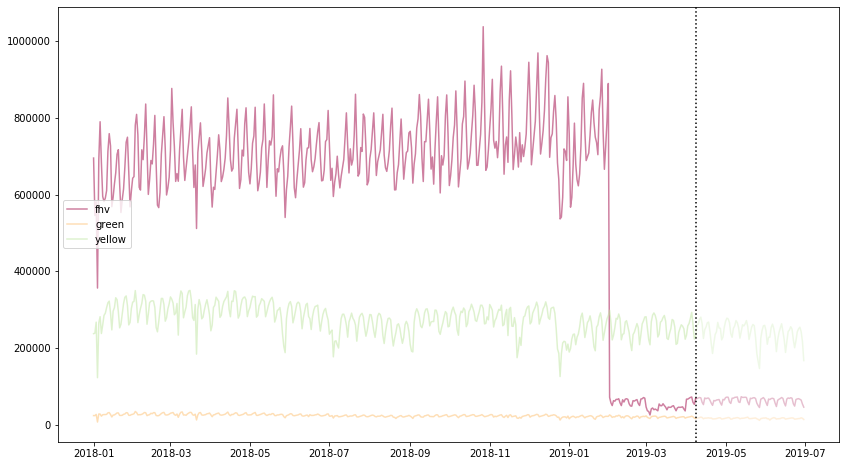

In [14]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#cols_float = time_series_df.drop(['pulocationid', 'dolocationid'], axis=1).columns
cols_float = time_series_df.columns
cmap = matplotlib.cm.get_cmap('Spectral')
colors = cmap(np.arange(0,len(cols_float))/len(cols_float))


plt.figure(figsize=[14,8]);
for c in range(len(cols_float)):
    plt.plot(time_series_df.loc[:end_training][cols_float[c]], alpha=0.5, color=colors[c], label=cols_float[c]);  
plt.legend(loc='center left');
for c in range(len(cols_float)):
    plt.plot(time_series_df.loc[end_training:][cols_float[c]], alpha=0.25, color=colors[c], label=None);
plt.axvline(x=end_training, color='k', linestyle=':');
#plt.text(time_series_df.index[int((time_series_df.shape[0]-n_weeks*prediction_length)*0.75)], time_series_df.max().max()/2, 'Train');
#plt.text(time_series_df.index[time_series_df.shape[0]-int(n_weeks*prediction_length/2)], time_series_df.max().max()/2, 'Test');
#plt.xlabel('Time');
#plt.show()

## Odd drop that we saw before
we still need to pull in the FHV HV dataset starting in Feb.  This represents the rideshare apps going to a difference licence type under the NYC TLC.

In [15]:
fhvhv_data = glueContext.create_dynamic_frame.from_catalog(database=database_name, table_name="fhvhv")
fhvhv_df = fhvhv_data.toDF().cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
from pyspark.sql.functions import to_date, lit
from pyspark.sql.types import TimestampType

dates = ("2018-01-01",  "2019-07-01")
date_from, date_to = [to_date(lit(s)).cast(TimestampType()) for s in dates]

fhvhv_df = fhvhv_df.where((fhvhv_df.pickup_datetime > date_from) & (fhvhv_df.pickup_datetime < date_to)).cache()
from pyspark.sql.functions import to_timestamp
fhvhv_df = fhvhv_df.withColumn("pickup_datetime", to_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
fhvhv_df.show(5, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|hvfhs_license_num|dispatching_base_num|pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|sr_flag|
+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|HV0003           |B02867              |2019-02-01 00:05:18|2019-02-01 00:14:57|245         |251         |null   |
|HV0003           |B02879              |2019-02-01 00:41:29|2019-02-01 00:49:39|216         |197         |null   |
|HV0005           |B02510              |2019-02-01 00:51:34|2019-02-01 01:28:29|261         |234         |null   |
|HV0005           |B02510              |2019-02-01 00:03:51|2019-02-01 00:07:16|87          |87          |null   |
|HV0005           |B02510              |2019-02-01 00:09:44|2019-02-01 00:39:56|87          |198         |null   |
+-----------------+--------------------+-------------------+-------------------+

In [19]:
from pyspark.sql.functions import col, max as max_, min as min_

## day = seconds*minutes*hours
unit = 60 * 60 * 24

epoch = (col("pickup_datetime").cast("bigint") / unit).cast("bigint") * unit

with_epoch = fhvhv_df.withColumn("epoch", epoch)

min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

ref = spark.range(
    min_epoch, max_epoch + 1, unit
).toDF("epoch")

resampled_fhvhv_df = (ref
    .join(with_epoch, "epoch", "left")
    .orderBy("epoch")
    .withColumn("ts_resampled", col("epoch").cast("timestamp")))

resampled_fhvhv_df = resampled_fhvhv_df.cache()

resampled_fhvhv_df.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+-------------------+
|epoch     |hvfhs_license_num|dispatching_base_num|pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|sr_flag|ts_resampled       |
+----------+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+-------------------+
|1548979200|HV0003           |B02867              |2019-02-01 00:05:18|2019-02-01 00:14:57|245         |251         |null   |2019-02-01 00:00:00|
|1548979200|HV0003           |B02879              |2019-02-01 00:41:29|2019-02-01 00:49:39|216         |197         |null   |2019-02-01 00:00:00|
|1548979200|HV0005           |B02510              |2019-02-01 00:51:34|2019-02-01 01:28:29|261         |234         |null   |2019-02-01 00:00:00|
|1548979200|HV0005           |B02510              |2019-02-01 00:03:51|2019-02-01 00:07:16|87          |87          |null   

In [20]:
from pyspark.sql import functions as func
#count_per_day_resamples = resampled_df.groupBy(["ts_resampled", "type", "pulocationid", "dolocationid"]).count()
count_per_day_resamples = resampled_fhvhv_df.groupBy(["ts_resampled"]).count()
count_per_day_resamples.cache()
count_per_day_resamples.show(10, False)
fhvhv_timeseries_df = count_per_day_resamples

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+
|ts_resampled       |count |
+-------------------+------+
|2019-06-18 00:00:00|692171|
|2019-03-21 00:00:00|809819|
|2019-05-03 00:00:00|815626|
|2019-05-12 00:00:00|857727|
|2019-04-25 00:00:00|689853|
|2019-03-10 00:00:00|812902|
|2019-04-30 00:00:00|655312|
|2019-06-26 00:00:00|663954|
|2019-06-06 00:00:00|682378|
|2019-02-06 00:00:00|663516|
+-------------------+------+
only showing top 10 rows

In [21]:
%%spark -o fhvhv_timeseries_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
%%local
fhvhv_timeseries_df = fhvhv_timeseries_df.rename(columns={"count": "fhvhv"})
fhvhv_timeseries_df = fhvhv_timeseries_df.set_index('ts_resampled', drop=True)

## Visualizing all the time series data
When we look at the FHVHV dataset starting in Feb 1st, you can see the time series looks normal and there isn't a giant drop in the dataset on that day.

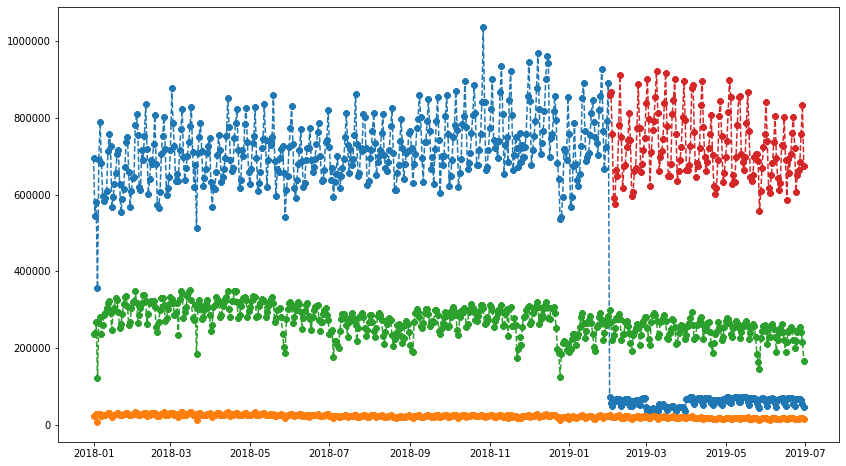

In [42]:
%%local
plt.figure(figsize=[14,8]);
plt.plot(time_series_df.join(fhvhv_timeseries_df), marker='8', linestyle='--')

## but now we need to combine the FHV and FHVHV dataset
Let's create a new dataset and call it full_fhv meaning both for-hire-vehicles and for-hire-vehicles high volume.

In [24]:
%%local
full_timeseries = time_series_df.join(fhvhv_timeseries_df)
full_timeseries = full_timeseries.fillna(0)
full_timeseries['full_fhv'] = full_timeseries['fhv'] + full_timeseries['fhvhv']
full_timeseries = full_timeseries.drop(['fhv', 'fhvhv'], axis=1)

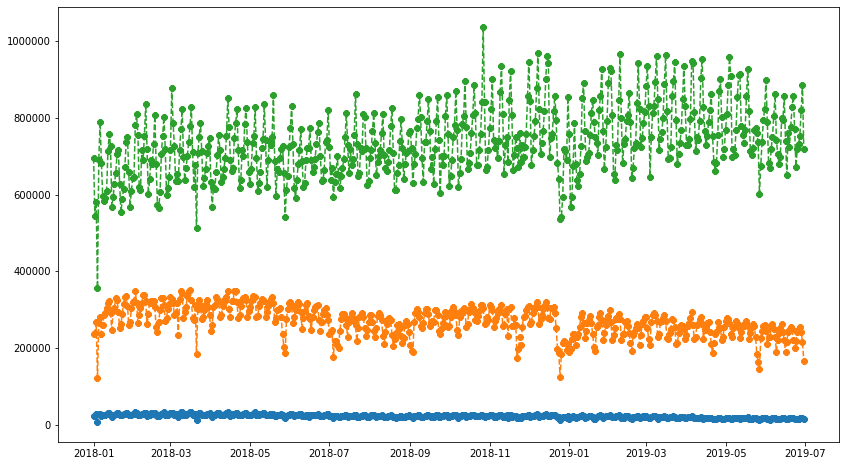

In [40]:
%%local
plt.figure(figsize=[14,8]);
plt.plot(full_timeseries, marker='8', linestyle='--')

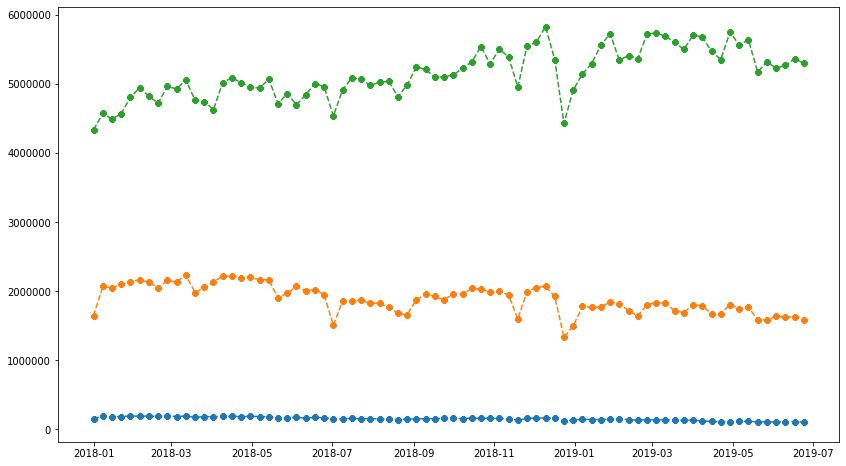

In [39]:
%%local
plt.figure(figsize=[14,8]);
plt.plot(full_timeseries.resample('7D', convention='end').sum(), marker='8', linestyle='--')

In [44]:
%%local
full_timeseries.isna().sum()

green       0
yellow      0
full_fhv    0
dtype: int64

In [62]:
%%local
import json
import boto3

bucket = 'sagemaker-us-east-1-783526147575'
key_prefix = '2019workshop/'

s3_client = boto3.client('s3')
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

encoding = "utf-8"
data = ''

for ts in time_series_training:
    data = data + series_to_jsonline(ts)
    data = data + '\n'
    
s3_client.put_object(Body=data.encode(encoding), Bucket=bucket, Key=key_prefix + 'data/train/train.json')
    

data = ''
for ts in time_series:
    data = data + series_to_jsonline(ts)
    data = data + '\n'

s3_client.put_object(Body=data.encode(encoding), Bucket=bucket, Key=key_prefix + 'data/test/test.json')


{'ResponseMetadata': {'RequestId': '533CAC49C7F43336',
  'HostId': 'wun5bVNSWv0/sYGWYwaFX6IqKmB0Pco6s4DiChHTLOeGOZykZKp3/cNmzB7uMmdoa/sx3m/ITTo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'wun5bVNSWv0/sYGWYwaFX6IqKmB0Pco6s4DiChHTLOeGOZykZKp3/cNmzB7uMmdoa/sx3m/ITTo=',
   'x-amz-request-id': '533CAC49C7F43336',
   'date': 'Sun, 13 Oct 2019 01:06:23 GMT',
   'etag': '"22723dba9b8f7c7e73c73b67e8ed22f6"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"22723dba9b8f7c7e73c73b67e8ed22f6"'}

In [57]:
%%local
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}data".format(bucket, key_prefix)
s3_output_path = "{}/{}output".format(bucket, key_prefix)
print('Data location: %s'%s3_data_path)
print('Output location: %s'%s3_output_path)

Data location: sagemaker-us-east-1-783526147575/2019workshop/data
Output location: sagemaker-us-east-1-783526147575/2019workshop/output


In [58]:
%%local

region = sagemaker_session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='DeepAR-forecast-taxidata',
    output_path="s3://" + s3_output_path
)

In [60]:
%%local
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "100",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)

In [63]:
%%local
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

2019-10-13 01:06:28 Starting - Starting the training job...
2019-10-13 01:06:30 Starting - Launching requested ML instances......
2019-10-13 01:07:33 Starting - Preparing the instances for training...
2019-10-13 01:08:11 Downloading - Downloading input data...
2019-10-13 01:08:52 Training - Training image download completed. Training in progress..Arguments: train
[10/13/2019 01:08:54 INFO 140349257213760] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u'

[10/13/2019 01:09:04 INFO 140349257213760] Epoch[28] Batch[10] avg_epoch_loss=11.071331
[10/13/2019 01:09:04 INFO 140349257213760] #quality_metric: host=algo-1, epoch=28, batch=10 train loss <loss>=11.1435050964
[10/13/2019 01:09:04 INFO 140349257213760] Epoch[28] Batch [10]#011Speed: 1428.58 samples/sec#011loss=11.143505
[10/13/2019 01:09:04 INFO 140349257213760] processed a total of 359 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 339.5969867706299, "sum": 339.5969867706299, "min": 339.5969867706299}}, "EndTime": 1570928944.168056, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1570928943.828017}

[10/13/2019 01:09:04 INFO 140349257213760] #throughput_metric: host=algo-1, train throughput=1056.78076936 records/second
[10/13/2019 01:09:04 INFO 140349257213760] #progress_metric: host=algo-1, completed 29 % of epochs
[10/13/2019 01:09:04 INFO 140349257213760] #quality_metric: host=algo-1, epoch=28, train loss <loss

#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 370.29314041137695, "sum": 370.29314041137695, "min": 370.29314041137695}}, "EndTime": 1570928954.374995, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1570928954.004779}

[10/13/2019 01:09:14 INFO 140349257213760] #test_score (algo-1, RMSE): 17760.1765757
[10/13/2019 01:09:14 INFO 140349257213760] #test_score (algo-1, mean_wQuantileLoss): 0.10519661
[10/13/2019 01:09:14 INFO 140349257213760] #test_score (algo-1, wQuantileLoss[0.1]): 0.046778638
[10/13/2019 01:09:14 INFO 140349257213760] #test_score (algo-1, wQuantileLoss[0.2]): 0.08157892
[10/13/2019 01:09:14 INFO 140349257213760] #test_score (algo-1, wQuantileLoss[0.3]): 0.10356046
[10/13/2019 01:09:14 INFO 140349257213760] #test_score (algo-1, wQuantileLoss[0.4]): 0.117397465
[10/13/2019 01:09:14 INFO 140349257213760] #test_score (algo-1, wQuantileLoss[0.5]): 0.12368922
[10/13/2019 01:09:14 INFO 140349257213760] #test_s

In [65]:
%%local
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [66]:
%%local
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor
)


---------------------------------------------------------------------------------------------------!

## .... To read while the endpoint is deploying....

Let’s elaborate on the DeepAR model's architecture by walking through an example. When interested in quantifying the confidence of the estimates produced, then it's probabilistic forecasts that are wanted. The data we’re working with is real-valued, so let’s opt for the Gaussian likelihood:
$$\ell(y_t|\mu_t,\sigma_t)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\frac{-(y_t-\mu_t)^2}{2\sigma^2}}.$$

$\theta$ represents the `parameters of the likelihood`. In the case of Gaussian, $\theta_t$ will represent the mean and standard deviation:  $$\theta_t = \{\mu_{t},\sigma_{t}\}.$$

The neural network’s last hidden layer results in $h_{d,t}$. This $h_{d,t}$ will undergo 1 activation function per likelihood parameter. For example, for the Gaussian likelihood, $h_{d,t}$ is transformed by an affine activation function to get the mean:
$$\mu_{t} = w_{\mu}^T h_{d,t} + b_{\mu},$$
and then $h$ is transformed by a softplus activation to get the standard deviation:
$$\sigma_t = \log\left(1 + \exp(w_{\sigma}^T h_{d,t} + b_{\sigma})\right).$$

The `activation parameters` are the $w_{\mu},b_{\mu},w_{\sigma},b_{\sigma}$ parameters within the activation functions. The NN is trained to learn the fixed constants of the activation parameters.  Since the $h_{d,t}$ output  vary given each time-step's input, this still allows the likelihood parameters to vary over time, and therefore capture dynamic behaviors in the time-series data.

![DeepAR Training](images/deepar_training.png)

From the above diagram, the <span style="color:green">green</span> input at each time-step is the data point preceding the current time-step’s data, as well as the previous network’s output. For simplicity, on this diagram we aren’t showing covariates which would also be input.

The LSTM layers are shown in <span style="color:red">red</span>, and the final hidden layer produces the $h_{d,t}$ value, which we saw in the previous slide will undergo an activation function for each parameter of the specified likelihood. To learn the activation function parameters, the NN takes the $h_{d,t}$ at time $t$ and the data up until time $t$, and performs Stochastic Gradient Descent (SGD) to yield the activation parameters which maximize the likelihood at time $t$. The <span style="color:blue">blue</span> output layer uses the SGD-optimized activation functions to output the maximum likelihood parameters.

This is how DeepAR trains its model to your data input. Now we want to DeepAR to give us probabilistic forecasts for the next time-step.

![DeepAR Forecast](images/deepar_forecast.png)

The <span style="color:magenta">pink</span> line marks our current point in time, divides our training data from data not yet seen. For the first input, it can use the data point of the current time. The input will be processed by the trained LSTM layers, and subsequently get activated by the optimized activation functions to output the maximum-likelihood theta parameters at time $t+1$. 

Now that DeepAR has completed the likelihood with its parameter estimates, DeepAR can simulate `Monte Carlo (MC) samples` from this likelihood and produce an empirical distribution for the predicted datapoint - the probabilistic forecasts shown in <span style="color:purple">purple</span>. The MC samples produced at time $t+1$ are used as input for time $t+2$, etc, until the end of the prediction horizon. In the interactive plots below, we'll see how Monte Carlo samples are able to provide us a confidence interval about the point estimate.


In [75]:
%%local
ABB = full_timeseries.asfreq('d')

In [81]:
%%local
print('Green Rides:')
print(predictor.predict(ts=ABB.loc[end_training:, 'green'], quantiles=[0.10, 0.5, 0.90], num_samples=100).head())
print('\nYellow Rides:')
print(predictor.predict(ts=ABB.loc[end_training:, 'yellow'], quantiles=[0.10, 0.5, 0.90], num_samples=100).head())
print('\nFHV Rides:')
print(predictor.predict(ts=ABB.loc[end_training:, 'full_fhv'], quantiles=[0.10, 0.5, 0.90], num_samples=100).head())

Green Rides:
                     0.1           0.5           0.9
2019-07-01  11696.563477  13904.709961  15993.275391
2019-07-02  12471.116211  14914.283203  16623.171875
2019-07-03  13116.726562  15247.833984  16880.519531
2019-07-04  14178.374023  15928.555664  17472.890625
2019-07-05  14434.592773  16769.384766  18430.316406

Yellow Rides:
                      0.1            0.5            0.9
2019-07-01  175893.859375  207219.656250  229232.093750
2019-07-02  213402.359375  238125.218750  265153.187500
2019-07-03  211633.953125  242357.671875  276456.406250
2019-07-04  216138.390625  243189.203125  277507.656250
2019-07-05  210033.875000  238050.812500  259129.984375

FHV Rides:
                    0.1          0.5          0.9
2019-07-01  619888.4375  731436.2500  815895.5000
2019-07-02  607809.2500  708945.4375  800879.8125
2019-07-03  594175.3125  703851.5000  801319.6250
2019-07-04  649068.3125  733550.5000  851867.3750
2019-07-05  729027.3125  802756.6875  925071.3750


In [168]:
%%local
import matplotlib
import matplotlib.pyplot as plt

def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80,
    num_samples=100,
    draw_color='blue'
):
    print("Calling endpoint to generate {} predictions starting from {} ...".format(target_ts.name, str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": num_samples
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    mccolor = draw_color
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                prediction[key].plot(color='light'+mccolor.replace('dark',''), alpha=0.2, label='_nolegend_')
                
                
    # the date didn't have a frequency in it, so setting it here.
    new_date = pd.Timestamp(forecast_date, freq='d')
    target_section = target_ts[new_date-plot_history:new_date+prediction_length]
    target_section.plot(color="black", label='target')
    plt.title(target_ts.name.upper(), color='darkred')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color=mccolor, alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color=mccolor, label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

In [169]:
%%local
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox, RadioButtons
import datetime

@interact_manual(
    series_type=RadioButtons(options=['full_fhv', 'yellow', 'green'], description='Type'),
    forecast_day=IntSlider(min=0, max=100, value=0, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    num_samples=IntSlider(min=100, max=1000, value=100, step=500, style=style),
    show_samples=Checkbox(value=True),
    continuous_update=False
)

def plot_interact(series_type, forecast_day, confidence, history_weeks_plot, show_samples, num_samples):   
    plot(
        predictor,
        target_ts=ABB[series_type].asfreq(freq='d', fill_value=0),
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * prediction_length,
        confidence=confidence,
        num_samples=num_samples
    )

interactive(children=(RadioButtons(description='Type', options=('full_fhv', 'yellow', 'green'), value='full_fh…

Calling endpoint to generate full_fhv predictions starting from 2019-04-08 00:00:00 ...
Calling endpoint to generate yellow predictions starting from 2019-04-08 00:00:00 ...
Calling endpoint to generate green predictions starting from 2019-04-08 00:00:00 ...


<Figure size 432x288 with 0 Axes>

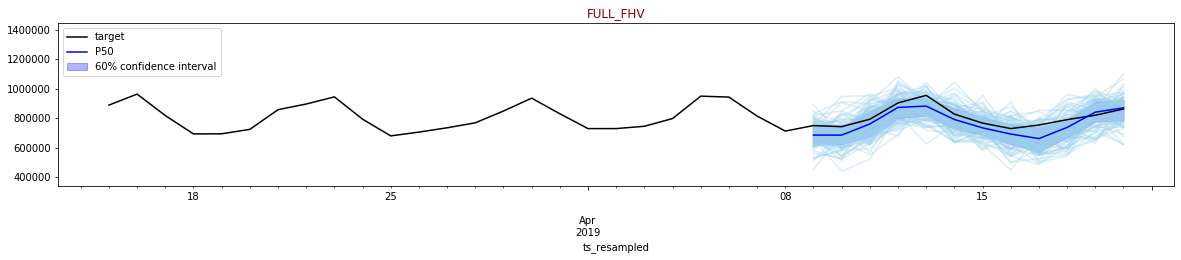

<Figure size 432x288 with 0 Axes>

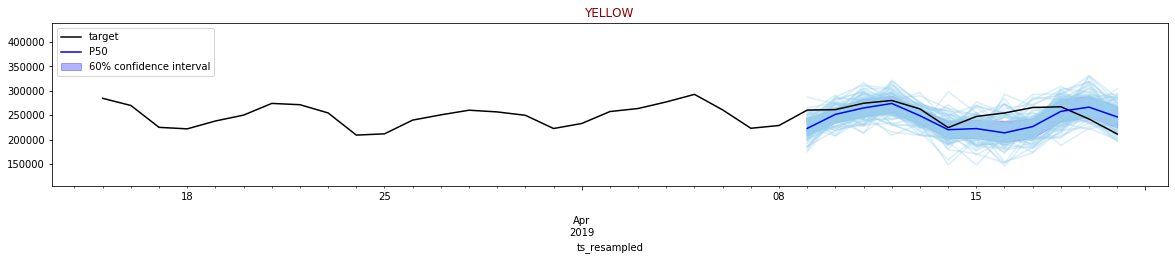

<Figure size 432x288 with 0 Axes>

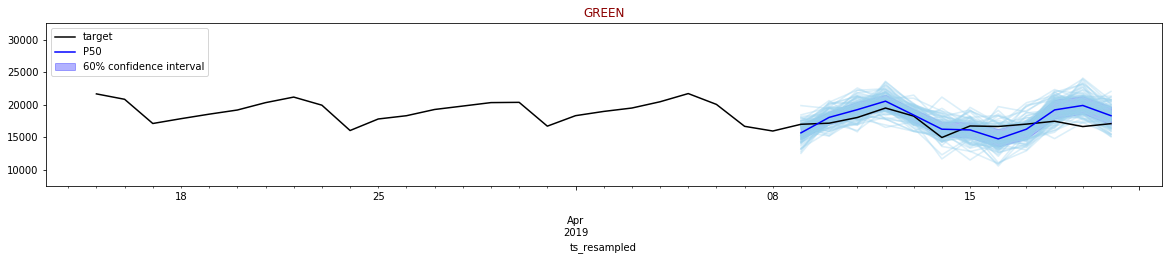

In [173]:
%%local
l = ['full_fhv', 'yellow', 'green']
for i in range(len(time_series_training)):
    plt.figure()
    plot(
        predictor,
        target_ts=ABB[l[i]],
        forecast_date=end_training,
        show_samples=True,
        plot_history= 2 * prediction_length,
        confidence=60,
    );